# Dataset 
https://archive.ics.uci.edu/dataset/942/rt-iot20221 The RT_IoT2022 dataset provides data for detecting anomalies in IoT network traffic. 

In [1]:
# !python -m pip install --upgrade pip
# pip install pandas-profiling
# %pip install umap-learn
# %pip install ydata-profiling


# libraries

In [2]:
import umap
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import cycle
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.model_selection import cross_val_score
from sklearn.utils import resample
from sklearn.metrics import classification_report, roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import label_binarize
from ydata_profiling import ProfileReport
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.naive_bayes import GaussianNB

In [3]:
RT_lot2022_data = pd.read_csv("RT_lot2022.csv")
RT_lot2022_data.head()

,Column1,id.orig_p,id.resp_p,proto,service,flow_duration,fwd_pkts_tot,bwd_pkts_tot,fwd_data_pkts_tot,bwd_data_pkts_tot,...,active.std,idle.min,idle.max,idle.tot,idle.avg,idle.std,fwd_init_window_size,bwd_init_window_size,fwd_last_window_size,Attack_type
0,0,38667,1883,tcp,mqtt,32.011598,9,5,3,3,...,0,29729182.96,29729182.96,29729182.96,29729182.96,0,64240,26847,502,MQTT_Publish
1,1,51143,1883,tcp,mqtt,31.883584,9,5,3,3,...,0,29855277.06,29855277.06,29855277.06,29855277.06,0,64240,26847,502,MQTT_Publish
2,2,44761,1883,tcp,mqtt,32.124053,9,5,3,3,...,0,29842149.02,29842149.02,29842149.02,29842149.02,0,64240,26847,502,MQTT_Publish
3,3,60893,1883,tcp,mqtt,31.961063,9,5,3,3,...,0,29913774.97,29913774.97,29913774.97,29913774.97,0,64240,26847,502,MQTT_Publish
4,4,51087,1883,tcp,mqtt,31.902362,9,5,3,3,...,0,29814704.90,29814704.90,29814704.90,29814704.90,0,64240,26847,502,MQTT_Publish


In [4]:
RT_lot2022_data.shape

(123117, 85)

In [5]:
RT_lot2022_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123117 entries, 0 to 123116
Data columns (total 85 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   Column1                   123117 non-null  int64  
 1   id.orig_p                 123117 non-null  int64  
 2   id.resp_p                 123117 non-null  int64  
 3   proto                     123117 non-null  object 
 4   service                   123117 non-null  object 
 5   flow_duration             123117 non-null  float64
 6   fwd_pkts_tot              123117 non-null  int64  
 7   bwd_pkts_tot              123117 non-null  int64  
 8   fwd_data_pkts_tot         123117 non-null  int64  
 9   bwd_data_pkts_tot         123117 non-null  int64  
 10  fwd_pkts_per_sec          123117 non-null  float64
 11  bwd_pkts_per_sec          123117 non-null  float64
 12  flow_pkts_per_sec         123117 non-null  float64
 13  down_up_ratio             123117 non-null  f

In [6]:
RT_lot2022_data.describe()

,Column1,id.orig_p,id.resp_p,flow_duration,fwd_pkts_tot,bwd_pkts_tot,fwd_data_pkts_tot,bwd_data_pkts_tot,fwd_pkts_per_sec,bwd_pkts_per_sec,...,active.avg,active.std,idle.min,idle.max,idle.tot,idle.avg,idle.std,fwd_init_window_size,bwd_init_window_size,fwd_last_window_size
count,123117.000000,123117.000000,123117.000000,123117.000000,123117.000000,123117.000000,123117.000000,123117.000000,1.231170e+05,1.231170e+05,...,1.231170e+05,1.231170e+05,1.231170e+05,1.231170e+05,1.231170e+05,1.231170e+05,1.231170e+05,123117.000000,123117.000000,123117.000000
mean,37035.089248,34639.258738,1014.305092,3.809566,2.268826,1.909509,1.471218,0.820260,3.518063e+05,3.517620e+05,...,1.481354e+05,2.353599e+04,1.616655e+06,1.701956e+06,3.517644e+06,1.664985e+06,4.550183e+04,6118.905123,2739.776018,751.647514
std,30459.106367,19070.620354,5256.371994,130.005408,22.336565,33.018311,19.635196,32.293948,3.707645e+05,3.708015e+05,...,1.613007e+06,1.477935e+06,8.809396e+06,9.252337e+06,1.229508e+08,9.007064e+06,1.091361e+06,18716.313861,10018.848534,6310.183843
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000
25%,6059.000000,17702.000000,21.000000,0.000001,1.000000,1.000000,1.000000,0.000000,7.454354e+01,7.288927e+01,...,9.536740e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,64.000000,0.000000,64.000000
50%,33100.000000,37221.000000,21.000000,0.000004,1.000000,1.000000,1.000000,0.000000,2.467238e+05,2.467238e+05,...,4.053116e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,64.000000,0.000000,64.000000
75%,63879.000000,50971.000000,21.000000,0.000005,1.000000,1.000000,1.000000,0.000000,5.242880e+05,5.242880e+05,...,5.006790e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,64.000000,0.000000,64.000000
max,94658.000000,65535.000000,65389.000000,21728.335580,4345.000000,10112.000000,4345.000000,10105.000000,1.048576e+06,1.048576e+06,...,4.374931e+08,4.774862e+08,3.000000e+08,3.000000e+08,2.096777e+10,3.000000e+08,1.208029e+08,65535.000000,65535.000000,65535.000000


In [7]:
RT_lot2022_data.isnull().sum().any

<bound method Series.any of Column1                 0
id.orig_p               0
id.resp_p               0
proto                   0
service                 0
                       ..
idle.std                0
fwd_init_window_size    0
bwd_init_window_size    0
fwd_last_window_size    0
Attack_type             0
Length: 85, dtype: int64>

### Reduce Instances

In [8]:
majority_class = RT_lot2022_data['Attack_type'].value_counts().idxmax()
max_class_size = 40000  
majority_class_data = RT_lot2022_data[RT_lot2022_data['Attack_type'] == majority_class]
minority_class_data = RT_lot2022_data[RT_lot2022_data['Attack_type'] != majority_class]
majority_class_downsampled = resample(majority_class_data,
                                      replace=False,   
                                      n_samples=max_class_size,  
                                      random_state=42)  
balanced_data = pd.concat([majority_class_downsampled, minority_class_data])
print("New class distribution:\n", balanced_data['Attack_type'].value_counts())
print("Shape of balanced data:", balanced_data.shape)
balanced_data.head()
RT_lot2022_data = balanced_data

New class distribution:
 Attack_type
DOS_SYN_Hping                 40000
Thing_Speak                    8108
ARP_poisioning                 7750
MQTT_Publish                   4146
NMAP_UDP_SCAN                  2590
NMAP_XMAS_TREE_SCAN            2010
NMAP_OS_DETECTION              2000
NMAP_TCP_scan                  1002
DDOS_Slowloris                  534
Wipro_bulb                      253
Metasploit_Brute_Force_SSH       37
NMAP_FIN_SCAN                    28
Name: count, dtype: int64
Shape of balanced data: (68458, 85)


# Feature

In [9]:
RT_lot2022_features = RT_lot2022_data.drop(columns=['Attack_type'], axis=1)
print("FEATURES:")
print(RT_lot2022_features)

FEATURES:
        Column1  id.orig_p  id.resp_p proto service  flow_duration  \
81670     60879      56922         21   tcp       -       0.000001   
37040     16249      19092         21   tcp       -       0.000004   
37463     16672      19515         21   tcp       -       0.000005   
70195     49404      52321         21   tcp       -       0.000000   
100153    79362      53360         21   tcp       -       0.000001   
...         ...        ...        ...   ...     ...            ...   
123112     2005      59247      63331   tcp       -       0.000006   
123113     2006      59247      64623   tcp       -       0.000007   
123114     2007      59247      64680   tcp       -       0.000006   
123115     2008      59247      65000   tcp       -       0.000006   
123116     2009      59247      65129   tcp       -       0.000006   

        fwd_pkts_tot  bwd_pkts_tot  fwd_data_pkts_tot  bwd_data_pkts_tot  ...  \
81670              1             1                  1               

 ### Remove constant columns

->Identifying and removing columns that have unique values less than or equal to 1

In [10]:
unique = RT_lot2022_features.nunique(axis=0)
for i in range(len(unique)):
    if unique[i] <= 1:
        print("Removing", RT_lot2022_features.axes[1][i])
        del RT_lot2022_features[RT_lot2022_features.axes[1][i]]

Removing bwd_URG_flag_count


C:\Users\Mano\AppData\Local\Temp\ipykernel_12316\2742802517.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if unique[i] <= 1:


### Identify categorical columns

In [11]:
print("Object DataType in Data:")
categorical_data = RT_lot2022_data.select_dtypes(include=['object']).columns.tolist()
print(categorical_data)
print("\nObject DataType in Features:")
categorical_Features = RT_lot2022_features.select_dtypes(include=['object']).columns.tolist()
print(categorical_Features)

Object DataType in Data:
['proto', 'service', 'Attack_type']

Object DataType in Features:
['proto', 'service']


### Encode categorical columns

In [12]:
# label encoding
unique_service = list(RT_lot2022_features["service"].unique())
RT_lot2022_features["service"] = RT_lot2022_features["service"].map(lambda x: unique_service.index(x))
unique_proto = list(RT_lot2022_features["proto"].unique())
RT_lot2022_features["proto"] = RT_lot2022_features["proto"].map(lambda x: unique_proto.index(x))

Identify categorical columns again

In [13]:
print("\nObject DataType in Features:")
categorical_Features = RT_lot2022_features.select_dtypes(include=['object']).columns.tolist()
print(categorical_Features)


Object DataType in Features:
[]


In [14]:
RT_lot2022_features.shape

(68458, 83)

### Normalize features

In [15]:
# Normalize each column to the range [0, 1]
RT_lot2022_normalized_features = pd.DataFrame(RT_lot2022_features)
for column in RT_lot2022_features.columns:
    col_min = RT_lot2022_features[column].min()
    col_max = RT_lot2022_features[column].max()
    RT_lot2022_normalized_features[column] =  ((RT_lot2022_features[column] - col_min) / (col_max - col_min)) 
print(RT_lot2022_normalized_features)
print(RT_lot2022_normalized_features.shape)

         Column1  id.orig_p  id.resp_p  proto  service  flow_duration  \
81670   0.643147   0.868574   0.000321    0.0      0.0   4.602285e-11   
37040   0.171660   0.291325   0.000321    0.0      0.0   1.840914e-10   
37463   0.176129   0.297780   0.000321    0.0      0.0   2.301143e-10   
70195   0.521921   0.798367   0.000321    0.0      0.0   0.000000e+00   
100153  0.838408   0.814221   0.000321    0.0      0.0   4.602285e-11   
...          ...        ...        ...    ...      ...            ...   
123112  0.021182   0.904051   0.968527    0.0      0.0   2.761371e-10   
123113  0.021192   0.904051   0.988285    0.0      0.0   3.221600e-10   
123114  0.021203   0.904051   0.989157    0.0      0.0   2.761371e-10   
123115  0.021213   0.904051   0.994051    0.0      0.0   2.761371e-10   
123116  0.021224   0.904051   0.996024    0.0      0.0   2.761371e-10   

        fwd_pkts_tot  bwd_pkts_tot  fwd_data_pkts_tot  bwd_data_pkts_tot  ...  \
81670        0.00023      0.000099        

### Remove highly correlated features

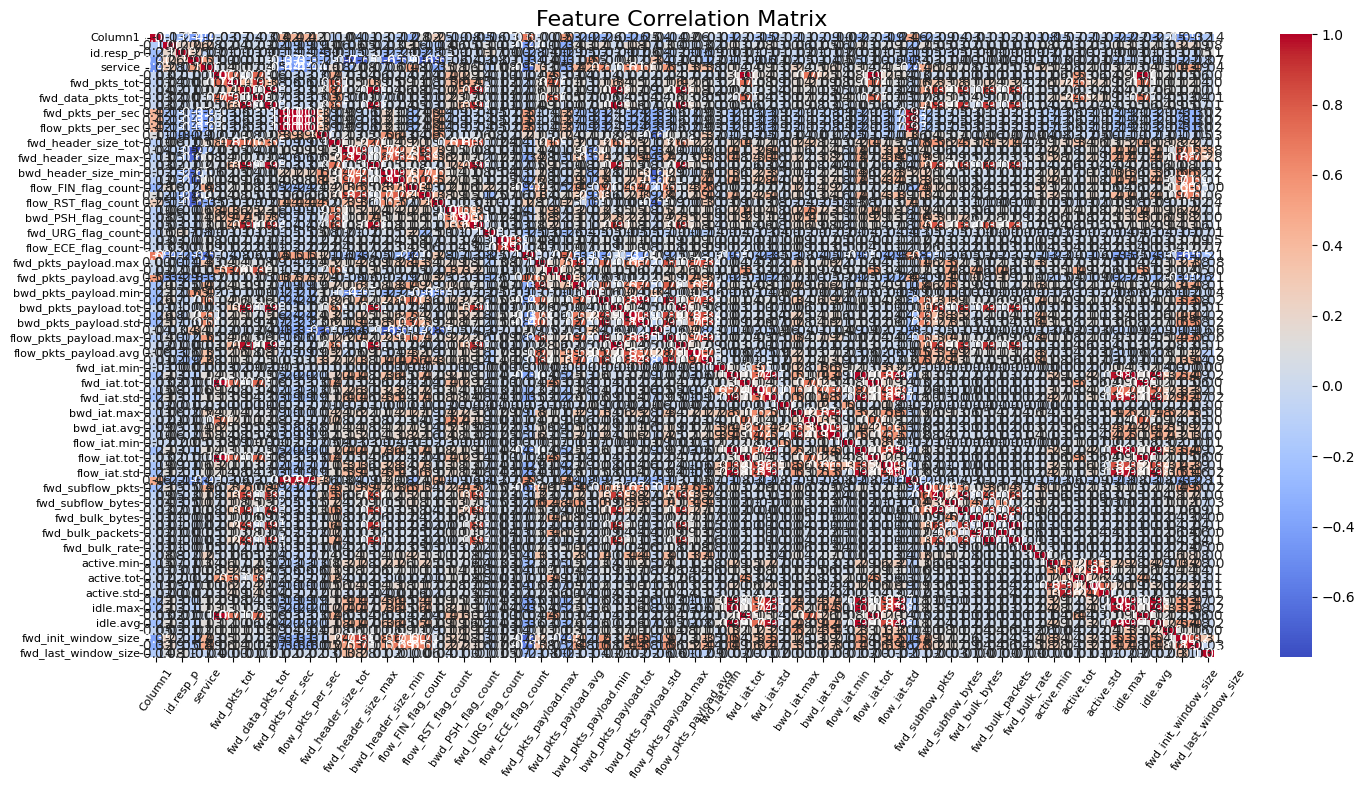

In [16]:

data_scaled_df = pd.DataFrame(RT_lot2022_normalized_features, columns=RT_lot2022_normalized_features.columns)

# Compute the correlation matrix
corr_matrix = data_scaled_df.corr()
# Plot the heatmap
plt.figure(figsize=(15, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)

plt.title("Feature Correlation Matrix", fontsize=16)
plt.xticks(rotation=55, fontsize=8)
plt.yticks(fontsize=8)
plt.tight_layout()  
plt.show()


In [17]:
# calculates the correlation matrix of the normalized features and identifies features that have a high correlation with each other (above a threshold of 0.9)
# clean up the dataset by removing redundant features, making it more efficient for modeling
correlation_matrix = RT_lot2022_normalized_features.corr().abs()
print(correlation_matrix)
upper_triangle = correlation_matrix.where(
    np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool)
)
to_drop = [column for column in upper_triangle.columns if any(upper_triangle[column] > 0.9)]

# Drop redundant features
RT_lot2022_red_data = RT_lot2022_normalized_features.drop(to_drop, axis=1)
RT_lot2022_red_data.shape
RT_lot2022_red_data.head()

                       Column1  id.orig_p  id.resp_p     proto   service  \
Column1               1.000000   0.134237   0.230740  0.398613  0.472801   
id.orig_p             0.134237   1.000000   0.196231  0.261826  0.280332   
id.resp_p             0.230740   0.196231   1.000000  0.250486  0.068949   
proto                 0.398613   0.261826   0.250486  1.000000  0.514964   
service               0.472801   0.280332   0.068949  0.514964  1.000000   
...                        ...        ...        ...       ...       ...   
idle.avg              0.219654   0.128981   0.005376  0.109558  0.128335   
idle.std              0.049811   0.029938   0.006027  0.018746  0.099844   
fwd_init_window_size  0.391057   0.224788   0.012629  0.216865  0.427446   
bwd_init_window_size  0.324981   0.192906   0.054803  0.179918  0.491116   
fwd_last_window_size  0.135505   0.081677   0.114255  0.073471  0.038336   

                      flow_duration  fwd_pkts_tot  bwd_pkts_tot  \
Column1             

,Column1,id.orig_p,id.resp_p,proto,service,flow_duration,fwd_pkts_tot,bwd_pkts_tot,fwd_pkts_per_sec,down_up_ratio,...,fwd_bulk_bytes,fwd_bulk_rate,bwd_bulk_rate,active.min,active.max,active.tot,idle.std,fwd_init_window_size,bwd_init_window_size,fwd_last_window_size
81670,0.643147,0.868574,0.000321,0.0,0.0,4.602285e-11,0.00023,0.000099,0.800000,0.16426,...,0.0,0.0,0.0,3.814600e-09,1.405608e-09,4.047550e-10,0.0,0.000977,0.0,0.000977
37040,0.171660,0.291325,0.000321,0.0,0.0,1.840914e-10,0.00023,0.000099,0.235294,0.16426,...,0.0,0.0,0.0,1.296964e-08,4.779066e-09,1.376167e-09,0.0,0.000977,0.0,0.000977
37463,0.176129,0.297780,0.000321,0.0,0.0,2.301143e-10,0.00023,0.000099,0.190476,0.16426,...,0.0,0.0,0.0,1.602132e-08,5.903552e-09,1.699971e-09,0.0,0.000977,0.0,0.000977
70195,0.521921,0.798367,0.000321,0.0,0.0,0.000000e+00,0.00023,0.000000,0.000000,0.00000,...,0.0,0.0,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000977,0.0,0.000977
100153,0.838408,0.814221,0.000321,0.0,0.0,4.602285e-11,0.00023,0.000099,1.000000,0.16426,...,0.0,0.0,0.0,3.051679e-09,1.124486e-09,3.238038e-10,0.0,0.000977,0.0,0.000977


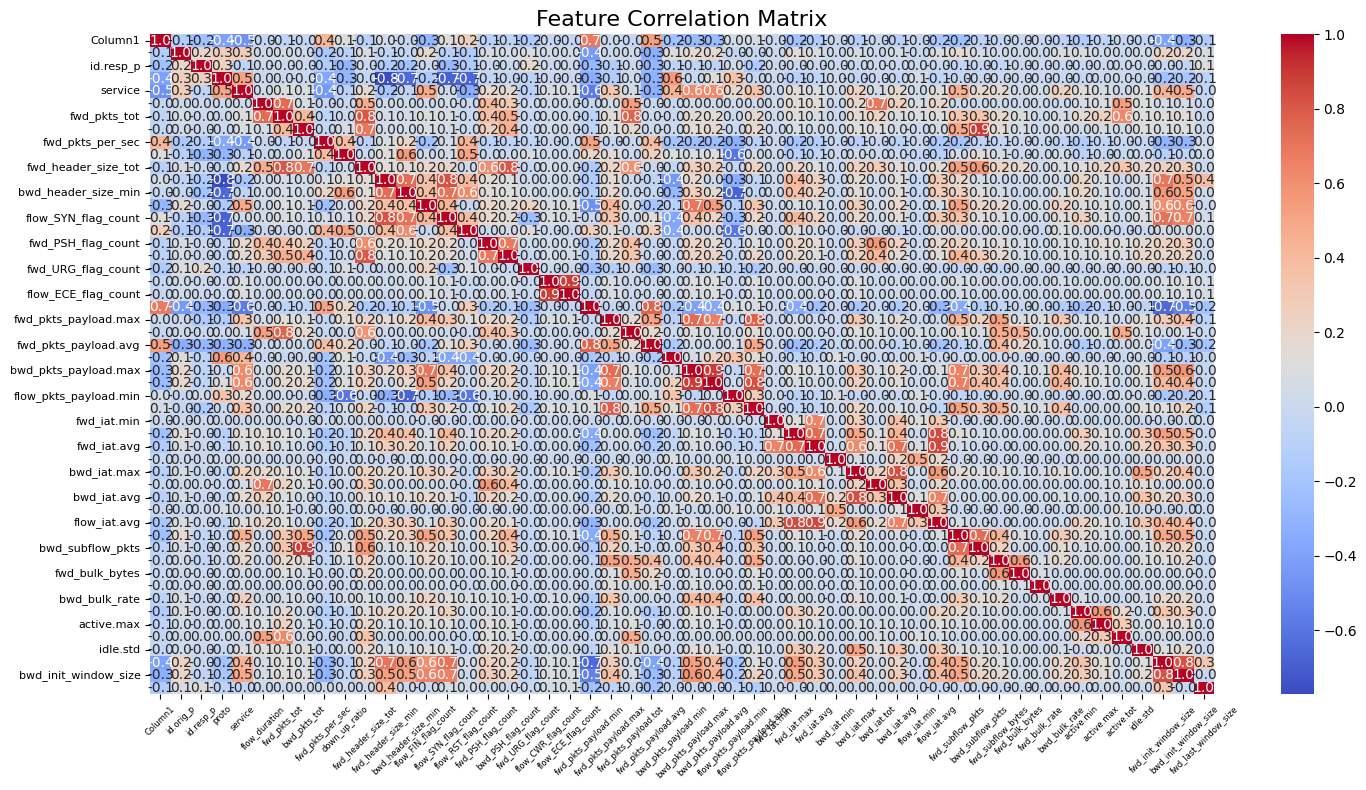

In [18]:

data_scaled_df = pd.DataFrame(RT_lot2022_red_data, columns=RT_lot2022_red_data.columns)
# Compute the correlation matrix
corr_matrix = data_scaled_df.corr()
# Plot the heatmap
plt.figure(figsize=(15, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".1f", cmap='coolwarm', cbar=True)

plt.title("Feature Correlation Matrix", fontsize=16)
plt.xticks(rotation=45, fontsize=6)
plt.yticks(fontsize=8)
plt.tight_layout()  
plt.show()


# Target

In [19]:
RT_lot2022_targets = RT_lot2022_data['Attack_type']
print("TARGET:")
print(RT_lot2022_targets)

TARGET:
81670           DOS_SYN_Hping
37040           DOS_SYN_Hping
37463           DOS_SYN_Hping
70195           DOS_SYN_Hping
100153          DOS_SYN_Hping
                 ...         
123112    NMAP_XMAS_TREE_SCAN
123113    NMAP_XMAS_TREE_SCAN
123114    NMAP_XMAS_TREE_SCAN
123115    NMAP_XMAS_TREE_SCAN
123116    NMAP_XMAS_TREE_SCAN
Name: Attack_type, Length: 68458, dtype: object


### Unique AttackTypes

In [20]:
unique_targets = RT_lot2022_data['Attack_type'].unique()
for target in unique_targets:
    print(target)

DOS_SYN_Hping
MQTT_Publish
Thing_Speak
Wipro_bulb
ARP_poisioning
DDOS_Slowloris
Metasploit_Brute_Force_SSH
NMAP_FIN_SCAN
NMAP_OS_DETECTION
NMAP_TCP_scan
NMAP_UDP_SCAN
NMAP_XMAS_TREE_SCAN


### Label Attack Types

In [21]:
class_mapping = {}
label = 0
for target in unique_targets:
    class_mapping[target] = label
    label += 1 
print(f"{'Target':<25}{'Label'}") 
for target, class_label in class_mapping.items():
    print(f"{target:<27}{class_label}")
RT_lot2022_data['RT_lot2022_Label'] = RT_lot2022_data['Attack_type'].map(class_mapping)
print("\n-----ASSIGN ATTACK TYPE-----")
print(RT_lot2022_data[['Attack_type', 'RT_lot2022_Label']])

Target                   Label
DOS_SYN_Hping              0
MQTT_Publish               1
Thing_Speak                2
Wipro_bulb                 3
ARP_poisioning             4
DDOS_Slowloris             5
Metasploit_Brute_Force_SSH 6
NMAP_FIN_SCAN              7
NMAP_OS_DETECTION          8
NMAP_TCP_scan              9
NMAP_UDP_SCAN              10
NMAP_XMAS_TREE_SCAN        11

-----ASSIGN ATTACK TYPE-----
                Attack_type  RT_lot2022_Label
81670         DOS_SYN_Hping                 0
37040         DOS_SYN_Hping                 0
37463         DOS_SYN_Hping                 0
70195         DOS_SYN_Hping                 0
100153        DOS_SYN_Hping                 0
...                     ...               ...
123112  NMAP_XMAS_TREE_SCAN                11
123113  NMAP_XMAS_TREE_SCAN                11
123114  NMAP_XMAS_TREE_SCAN                11
123115  NMAP_XMAS_TREE_SCAN                11
123116  NMAP_XMAS_TREE_SCAN                11

[68458 rows x 2 columns]


In [22]:
X = RT_lot2022_red_data.values  
y = RT_lot2022_data['RT_lot2022_Label'].values    

### Attack Type Distribution Plot

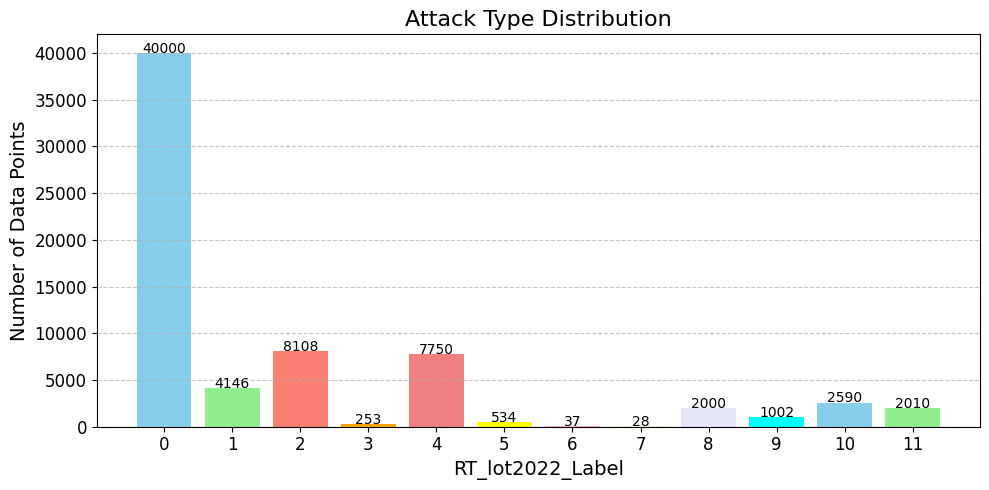

In [23]:
colors = ['skyblue', 'lightgreen', 'salmon', 'orange', 'lightcoral', 'yellow', 'lightpink', 'beige', 'lavender', 'cyan']
unique_classes, counts = np.unique(y, return_counts=True)
color_cycle = cycle(colors)
plt.figure(figsize=(10, 5))
bars = plt.bar(unique_classes, counts, color=[next(color_cycle) for _ in unique_classes])
plt.xlabel('RT_lot2022_Label', fontsize=14)
plt.ylabel('Number of Data Points', fontsize=14)
plt.title('Attack Type Distribution', fontsize=16)
plt.xticks(unique_classes, fontsize=12)
plt.yticks(fontsize=12)
for i, count in enumerate(counts):
    plt.text(unique_classes[i], count + 5, str(count), ha='center', fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


Preview DataFrame Structures

In [24]:
print("DataFrame data preview:",RT_lot2022_data.shape)
print("Features data preview:",RT_lot2022_red_data.shape)
print("Targets data preview:",RT_lot2022_targets.shape)

DataFrame data preview: (68458, 86)
Features data preview: (68458, 52)
Targets data preview: (68458,)


# RT_Iot2022 Report of clean data

In [25]:

# data = RT_lot2022_red_data
# data["Attack_type"] = RT_lot2022_targets
# profile = ProfileReport(
#     data,
#     title="RT_Iot2022 Profiling Report",
#     minimal=True  
# )
# profile.to_file("RT_Iot2022_profiling_report.html")
# print("Minimal profiling report has been generated and saved.")


# Supervisied Naive Base Classification

### Data Splitting 

In [26]:
# Split the data
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(RT_lot2022_red_data, RT_lot2022_targets, test_size=0.2, random_state=42)

RT_lot2022_train_data = pd.DataFrame(x_train)
RT_lot2022_train_data['RT_lot2022_Label'] = y_train  # Add labels as the last column

RT_lot2022_test_data = pd.DataFrame(x_test)
RT_lot2022_test_data['RT_lot2022_Label'] = y_test  

RT_lot2022_train_data.to_csv('train_data.csv', index=False)
RT_lot2022_test_data.to_csv('test_data.csv', index=False)
print("Training and testing data have been saved as 'train_data.csv' and 'test_data.csv'.")

Training and testing data have been saved as 'train_data.csv' and 'test_data.csv'.


Preview DataFrame Structures

In [27]:
print("DataFrame data preview:",RT_lot2022_data.shape)
print("Features data preview:",RT_lot2022_red_data.shape)
print("Targets data preview:",RT_lot2022_targets.shape)
print("Train data preview:",RT_lot2022_train_data.shape)
print("Test data preview:",RT_lot2022_test_data.shape)

DataFrame data preview: (68458, 86)
Features data preview: (68458, 52)
Targets data preview: (68458,)
Train data preview: (54766, 53)
Test data preview: (13692, 53)


### Gaussian Naive Bayes Model

# Evaluate Model Performance

In [29]:
report=classification_report(y_pred,y_test)
print(report)


                            precision    recall  f1-score   support

            ARP_poisioning       0.44      0.96      0.60       716
            DDOS_Slowloris       0.98      0.48      0.64       254
             DOS_SYN_Hping       1.00      1.00      1.00      7969
              MQTT_Publish       0.98      1.00      0.99       838
Metasploit_Brute_Force_SSH       0.60      0.35      0.44        17
             NMAP_FIN_SCAN       0.50      0.11      0.18         9
         NMAP_OS_DETECTION       1.00      1.00      1.00       403
             NMAP_TCP_scan       1.00      1.00      1.00       216
             NMAP_UDP_SCAN       0.94      0.48      0.63       975
       NMAP_XMAS_TREE_SCAN       0.99      1.00      1.00       392
               Thing_Speak       0.89      0.77      0.83      1864
                Wipro_bulb       0.33      0.46      0.39        39

                  accuracy                           0.92     13692
                 macro avg       0.80      0.7

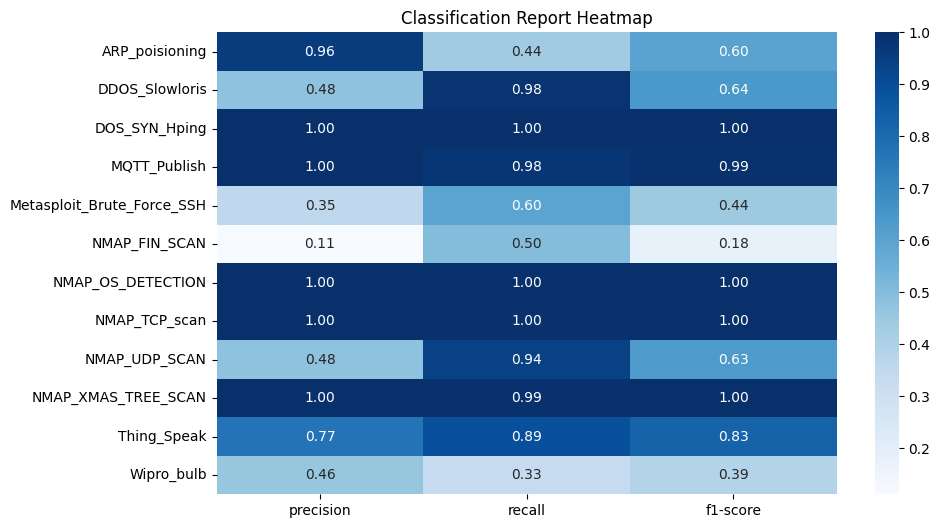

In [30]:
report = classification_report(y_test, y_pred, output_dict=True)
report_df = pd.DataFrame(report).transpose()

plt.figure(figsize=(10, 6))
sns.heatmap(report_df.iloc[:-3, :-1].astype(float), annot=True, cmap='Blues', fmt='.2f', cbar=True)
plt.title("Classification Report Heatmap")
plt.show()


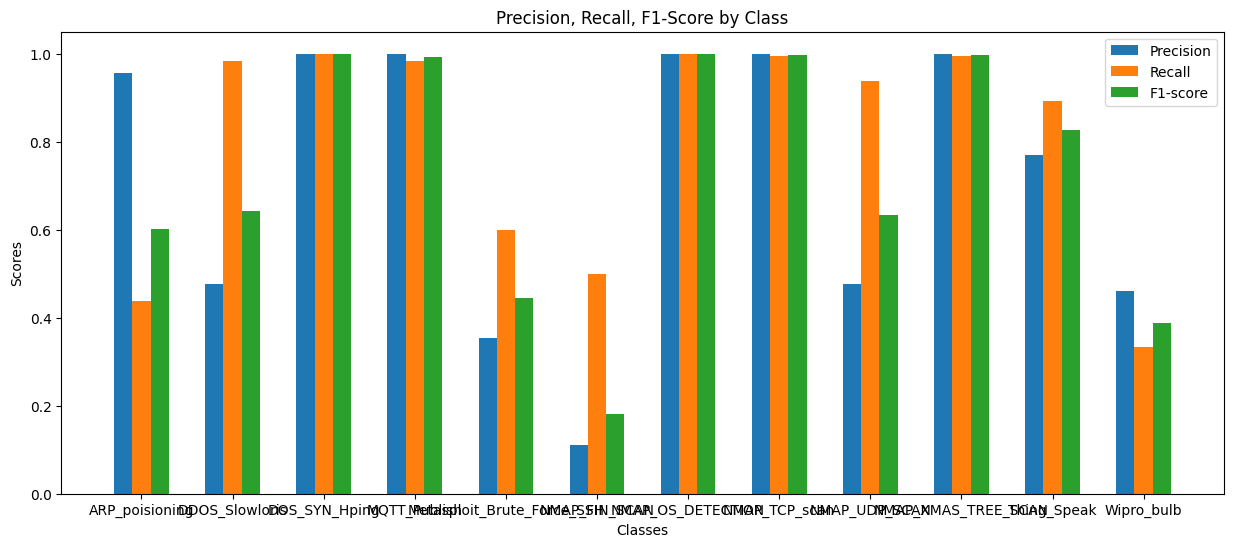

In [31]:
report = classification_report(y_test, y_pred, output_dict=True)
metrics = ["precision", "recall", "f1-score"]
classes = list(report.keys())[:-3]  # Exclude 'accuracy', 'macro avg', 'weighted avg'

x = np.arange(len(classes))
width = 0.2

fig, ax = plt.subplots(figsize=(15, 6))
for i, metric in enumerate(metrics):
    values = [report[cls][metric] for cls in classes]
    ax.bar(x + i * width, values, width, label=metric.capitalize())

ax.set_xlabel('Classes')
ax.set_ylabel('Scores')
ax.set_title('Precision, Recall, F1-Score by Class')
ax.set_xticks(x + width)
ax.set_xticklabels(classes)
ax.legend()
plt.show()



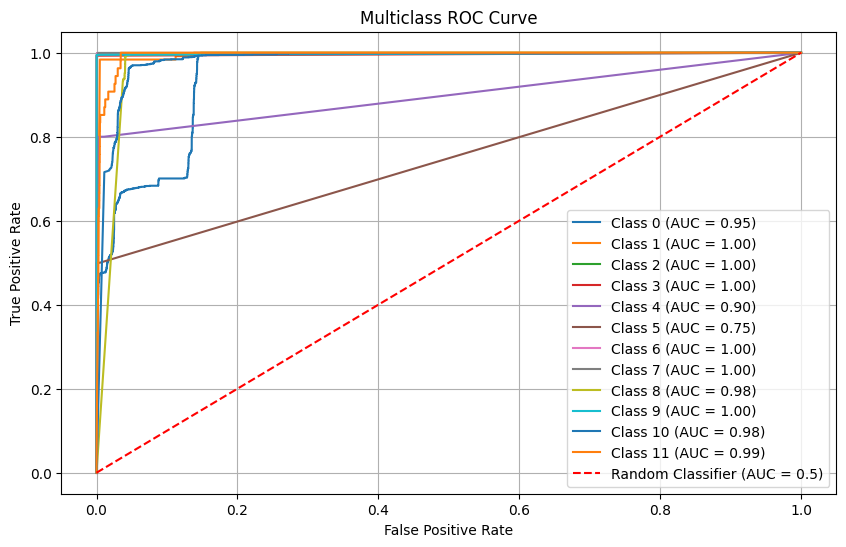

In [32]:
y_test_bin = label_binarize(y_test, classes=np.unique(y_test))
y_prob = model.predict_proba(x_test)

plt.figure(figsize=(10, 6))

for i in range(y_test_bin.shape[1]):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_prob[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Class {i} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'r--', label='Random Classifier (AUC = 0.5)')

plt.title('Multiclass ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


<Figure size 1000x600 with 0 Axes>

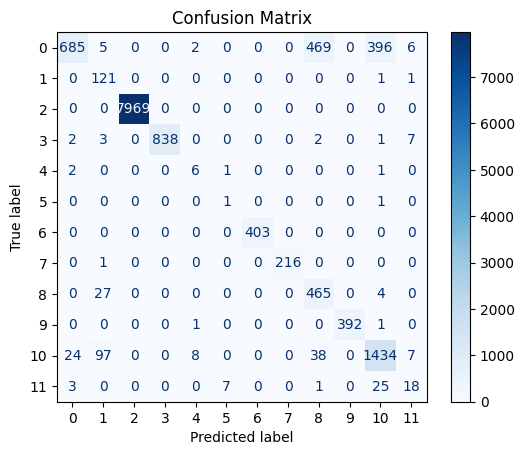

In [33]:
# Confusion Matrix
plt.figure(figsize=(10, 6))
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()


# kmean

### Elbow 

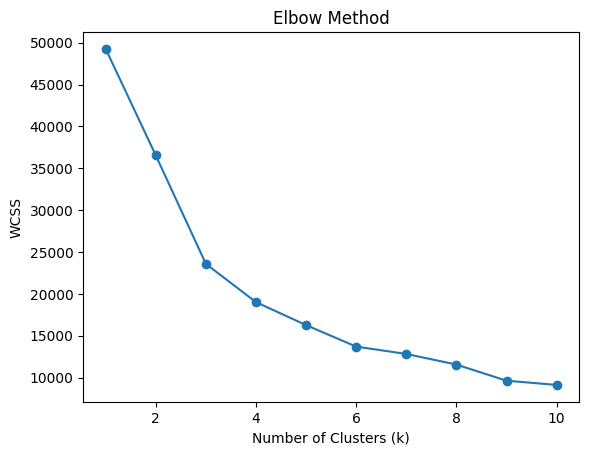

In [34]:
wcss = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(RT_lot2022_red_data)
    wcss.append(kmeans.inertia_)

# Plot the elbow graph
plt.plot(range(1, 11), wcss, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('WCSS')
plt.show()


###  Apply PCA for Dimensionality Reduction  
We start by applying PCA (Principal Component Analysis) to reduce the data to 10 components for faster processing. This will help in visualizing and clustering the data more effectively.


In [35]:
def apply_pca(data, n_components=10):
    print("Starting PCA...")
    pca = PCA(n_components=n_components)
    pca_result = pca.fit_transform(data)
    print("PCA completed.")
    return pca_result

### UMAP Visualization  
Next, we apply UMAP (Uniform Manifold Approximation and Projection) for a 2D visualization of the data, allowing us to see how the data is distributed 


In [36]:
def apply_umap(data):
    umap_model = umap.UMAP(n_components=2, n_neighbors=15, min_dist=0.1)
    return umap_model.fit_transform(data)

### Step 3: K-Means Clustering  
In this step, we perform K-Means clustering by initializing random centroids and iteratively updating them. The centroids' movements are tracked over iterations.


In [41]:
def apply_kmeans(pca_result, n_clusters=3):
    print("Starting K-Means clustering...")
    kmeans = KMeans(n_clusters=n_clusters)
    kmeans.fit(pca_result)
    print("K-Means clustering completed.")
    return kmeans.labels_

### Step 4: Visualizing Centroid Movements  
Finally, we visualize the K-Means clustering results. The data points are color-coded based on their cluster assignments, and the movement of centroids over iterations is plotted to show how they converge.


Starting PCA...
PCA completed.
Starting K-Means clustering...
K-Means clustering completed.
Silhouette Score: 0.5435
Starting UMAP visualization (Before Clustering)...


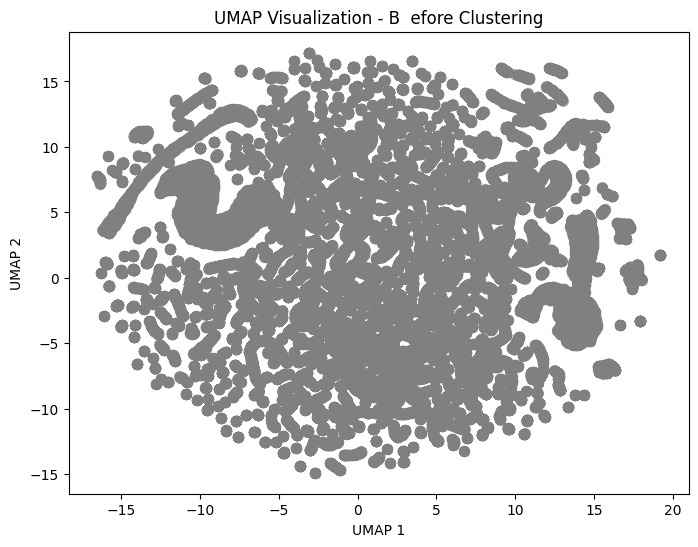

Starting UMAP visualization (After Clustering)...


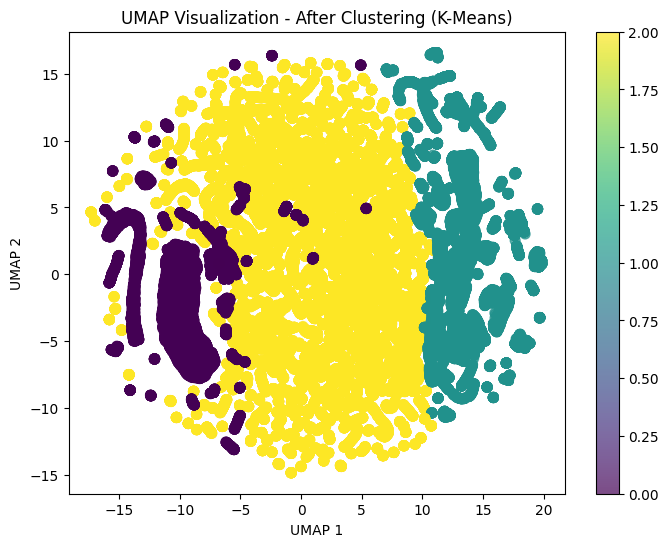

In [42]:
from sklearn.metrics import silhouette_score
pca_result = apply_pca(RT_lot2022_red_data)
labels = apply_kmeans(pca_result, n_clusters=3)
sil_score = silhouette_score(RT_lot2022_red_data, labels)
print(f'Silhouette Score: {sil_score:.4f}')
print("Starting UMAP visualization (Before Clustering)...")
umap_result= apply_umap(pca_result)
plt.figure(figsize=(8, 6))
plt.scatter(umap_result[:, 0], umap_result[:, 1], c='gray', s=50, alpha=0.5)
plt.title("UMAP Visualization - B  efore Clustering")
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.show()

RT_lot2022_red_data['Cluster'] = labels
print("Starting UMAP visualization (After Clustering)...")
umap_result_after_clustering = apply_umap(pca_result)
plt.figure(figsize=(8, 6))
plt.scatter(umap_result_after_clustering[:, 0], umap_result_after_clustering[:, 1], 
            c=RT_lot2022_red_data['Cluster'], cmap='viridis', s=50, alpha=0.7)
plt.title("UMAP Visualization - After Clustering (K-Means)")
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.colorbar()
plt.show()

# UI Kmean

Starting PCA...
PCA completed.
Starting K-Means clustering...
K-Means clustering completed.


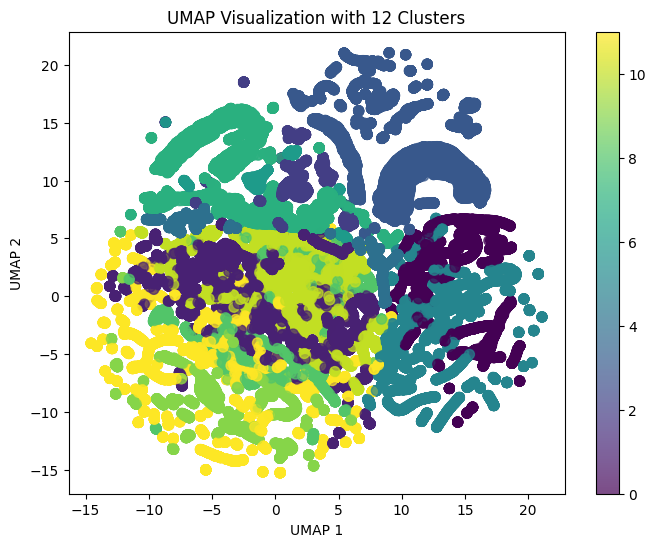

In [ ]:
import tkinter as tk
from tkinter import ttk

def plot_graph():
    try:
        n_clusters = int(cluster_input.get())
        if n_clusters < 1 or n_clusters > 14:
            raise ValueError("Number of clusters should be between 1 and 10.")
    except ValueError as e:
        error_label.config(text=f"Error: {e}")
        return

    plot_type = plot_selection.get()
    if plot_type == "":
        error_label.config(text="Error: Please select a plot type.")
        return

    pca_result = apply_pca(RT_lot2022_red_data)
    
    labels = apply_kmeans(pca_result, n_clusters=n_clusters)
    RT_lot2022_red_data['Cluster'] = labels
    
    umap_result = apply_umap(pca_result)
    
    plt.figure(figsize=(8, 6))
    if plot_type == "Scatter Plot":
        plt.scatter(umap_result[:, 0], umap_result[:, 1], c=labels, cmap='viridis', s=50, alpha=0.7)
        plt.title(f"UMAP Visualization with {n_clusters} Clusters")
        plt.xlabel("UMAP 1")
        plt.ylabel("UMAP 2")
        plt.colorbar()
    elif plot_type == "Elbow Method":
        distortions = []
        k_values = range(1, 10)
        for k in k_values:
            km = KMeans(n_clusters=k)
            km.fit(pca_result)
            distortions.append(km.inertia_)
        plt.plot(k_values, distortions, marker='o')
        plt.title("Elbow Method")
        plt.xlabel("Number of clusters")
        plt.ylabel("Distortion")
    elif plot_type == "3D Plot":
        if pca_result.shape[1] > 2:
            fig = plt.figure()
            ax = fig.add_subplot(111, projection='3d')
            ax.scatter(pca_result[:, 0], pca_result[:, 1], pca_result[:, 2], c=labels, cmap='viridis', s=50)
            ax.set_title(f"3D Plot with {n_clusters} Clusters")
            ax.set_xlabel("PCA 1")
            ax.set_ylabel("PCA 2")
            ax.set_zlabel("PCA 3")
        else:
            plt.scatter(umap_result[:, 0], umap_result[:, 1], c=labels, cmap='viridis', s=50, alpha=0.7)
            plt.title(f"2D UMAP with {n_clusters} Clusters")
            plt.xlabel("UMAP 1")
            plt.ylabel("UMAP 2")
            plt.colorbar()
    
    plt.show()

# Create the GUI
root = tk.Tk()
root.title("K-Means & UMAP Visualization")

# Cluster Selection
ttk.Label(root, text="Select Number of Clusters:").grid(row=0, column=0, padx=10, pady=10)
cluster_input = ttk.Entry(root)
cluster_input.grid(row=0, column=1, padx=10, pady=10)

# Plot Type Selection
ttk.Label(root, text="Select Plot Type:").grid(row=1, column=0, padx=10, pady=10)
plot_selection = ttk.Combobox(root, values=["Scatter Plot", "Elbow Method", "3D Plot"])
plot_selection.grid(row=1, column=1, padx=10, pady=10)

# Error message display
error_label = ttk.Label(root, text="", foreground="red")
error_label.grid(row=3, columnspan=2, pady=10)

# Generate Button
generate_button = ttk.Button(root, text="Generate Plot", command=plot_graph)
generate_button.grid(row=2, columnspan=2, pady=20)

root.mainloop()
